<a href="https://colab.research.google.com/github/yunju-1118/EWHA/blob/main/HW7_StatisticalProgramming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 4.1 HW problem


We consider the Boston housing data, where the response variable is the median house value `medv` (in \$1000s). We want to model `medv` using the predictors `lstat` (lower status of the population, in %) and `age` (proportion of units built prior to 1940).

Train two models and compare the test mean squared error (MSE) of the following two models.

**Model 1 (two predictors)**  
We fit the linear regression model
$$
\texttt{medv}_i \sim N(\beta_0 + \beta_1\,\texttt{lstat}_i + \beta_2\,\texttt{age}_i,\, \sigma^2),
\qquad i = 1, \ldots, n.
$$

**Model 2 (one predictor)**  
We fit the reduced model that uses `lstat` only:
$$
\texttt{medv}_i \sim N(\beta_0 + \beta_1\,\texttt{lstat}_i,\, \sigma^2),
\qquad i = 1, \ldots, n.
$$

Using the following custom layer
```
class GaussianRegModel(nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas =
        self.sigma =

    def forward(self, X):
        mu =
        return mu

    def loss(self, mu, y):
        ll =
        nll = -torch.sum(ll)
        return nll

forward1 = GaussianRegModel(3)
forward2 = GaussianRegModel(2)
```

Hint:
1. You first want to make dataset(s) and dataloader(s) first.
2. Use the below code to have the data.

In [1]:
import pandas as pd
import torch

# 1. Load CSV
df = pd.read_csv("Boston.csv")

# 2. Convert to tensor
data = torch.tensor(df.values, dtype=torch.float32)

# 3. Shuffle rows manually
n = data.shape[0]
perm = torch.randperm(n)

shuffled = data[perm]

# 4. Train/Test split (70% train, 30% test)
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# 5. Split into X and y
X_train = train[:, :-1]
y_train = train[:, -1:]

X_test = test[:, :-1]
y_test = test[:, -1:]

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Train X: torch.Size([354, 12])
Train y: torch.Size([354, 1])
Test X: torch.Size([152, 12])
Test y: torch.Size([152, 1])


### **Model 1**

In [2]:
# Dataset 정의

## Normalization
X_train_mean = torch.mean(X_train[:,[6,11]], axis=0)
X_train_sd = torch.std(X_train[:,[6,11]], axis=0)

ones = torch.ones([X_train.shape[0],1])
XX = (X_train[:,[6,11]]-X_train_mean)/X_train_sd
# XX_train = torch.stack([ones, X_train[:,6], X_train[:,11]], axis=1)
XXX_train = torch.concat([ones, XX], axis=1)

ones = torch.ones([X_test.shape[0],1])
XX = (X_test[:,[6,11]]-X_train_mean)/X_train_sd
# XX_test = torch.stack([ones, X_test[:,6], X_test[:,11]], axis=1)
XXX_test = torch.concat([ones, XX], axis=1)

In [3]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [4]:
# DataLoader 정의

train = TensorDataset(XXX_train, y_train)  # [-1,3], [-1,1]
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(XXX_test, y_test)  # [-1,3], [-1,1]
test_loader = DataLoader(test, shuffle=False, batch_size=20)

In [5]:
class GaussianRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p,1]))
        self.sigma = torch.nn.Parameter(torch.abs(torch.randn([1])))  # 항상 양수 -> torch.abs

    def forward(self, X):
        mu = X@self.betas
        return mu

    def loss(self, mu, y):
        ll = -0.5*torch.log(2*torch.pi*self.sigma**2) - (y-mu)**2/(2*self.sigma**2)   # log-likelihood, [n,1]
        nll = -torch.sum(ll)  # negative log-likelihood
        return nll

forward1 = GaussianRegModel(3)
forward2 = GaussianRegModel(2)

In [6]:
lr = 0.01
optimizer= torch.optim.SGD(forward1.parameters(), lr=lr)


history=[]

for i in range(1000):
    LOSS=0
    for xx, yy in train_loader:   # xx:[-1,3], yy:[-1,1]
        uhat = forward1(xx)  # [-1,1]
        loss= forward1.loss(uhat,yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS+=loss.item()

    history.append(LOSS)

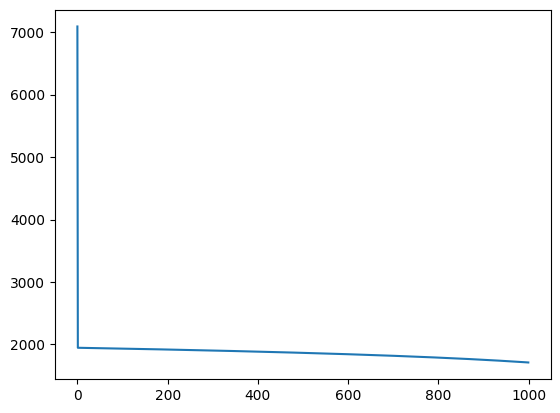

In [7]:
import matplotlib.pyplot as plt

plt.plot(history)

In [8]:
print(forward1.state_dict())

OrderedDict({'betas': tensor([[13.1376],
        [-2.0268],
        [-3.4488]]), 'sigma': tensor([48.7547])})


In [9]:
# test MSE?

S = 0

for xx, yy in test_loader:
    uhat = forward1(xx)
    sum_loss = torch.sum((yy-uhat)**2)
    S += sum_loss

print(S/len(test_loader.dataset))

tensor(148.0310, grad_fn=<DivBackward0>)


In [10]:
# Prediction of b0 = 11, b1=-1.2, b2-3.4
b0 = 11
b1=-1.2
b2=-3.4

yhat = b0 + b1*(65.2-X_train_mean[0])/X_train_sd[0] + b2*(4.98-X_train_mean[1])/X_train_sd[1]
print(yhat)

tensor(14.6766)


$y_i = \beta0 + \beta1 * \frac{X_{1i} - a}{c}+ \beta2 * \frac{X_{2i}-b}{d}$

a = mean(train X1)

b = mean(train X2)

c = sd(train X1)

d = sd(train X2)

### **Model 2**

In [11]:
# Dataset 정의

## Normalization
X_train_mean = torch.mean(X_train[:,[11]], axis=0)
X_train_sd = torch.std(X_train[:,[11]], axis=0)

ones = torch.ones([X_train.shape[0],1])
XX = (X_train[:,[11]]-X_train_mean)/X_train_sd
# XX_train = torch.stack([ones, X_train[:,6], X_train[:,11]], axis=1)
XXX_train = torch.concat([ones, XX], axis=1)

ones = torch.ones([X_test.shape[0],1])
XX = (X_test[:,[11]]-X_train_mean)/X_train_sd
# XX_test = torch.stack([ones, X_test[:,6], X_test[:,11]], axis=1)
XXX_test = torch.concat([ones, XX], axis=1)

In [12]:
# DataLoader 정의

train = TensorDataset(XXX_train, y_train)  # [-1,3], [-1,1]
train_loader = DataLoader(train, shuffle=True, batch_size=20)

test = TensorDataset(XXX_test, y_test)  # [-1,3], [-1,1]
test_loader = DataLoader(test, shuffle=False, batch_size=20)

In [13]:
class GaussianRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p,1]))
        self.sigma = torch.nn.Parameter(torch.abs(torch.randn([1])))  # 항상 양수 -> torch.abs

    def forward(self, X):
        mu = X@self.betas
        return mu

    def loss(self, mu, y):
        ll = -0.5*torch.log(2*torch.pi*self.sigma**2) - (y-mu)**2/(2*self.sigma**2)   # log-likelihood, [n,1]
        nll = -torch.sum(ll)  # negative log-likelihood
        return nll

forward1 = GaussianRegModel(3)
forward2 = GaussianRegModel(2)

In [14]:
lr = 0.01
optimizer= torch.optim.SGD(forward2.parameters(), lr=lr)


history=[]

for i in range(1000):
    LOSS=0
    for xx, yy in train_loader:   # xx:[-1,3], yy:[-1,1]
        uhat = forward2(xx)  # [-1,1]
        loss= forward2.loss(uhat,yy)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        LOSS+=loss.item()

    history.append(LOSS)

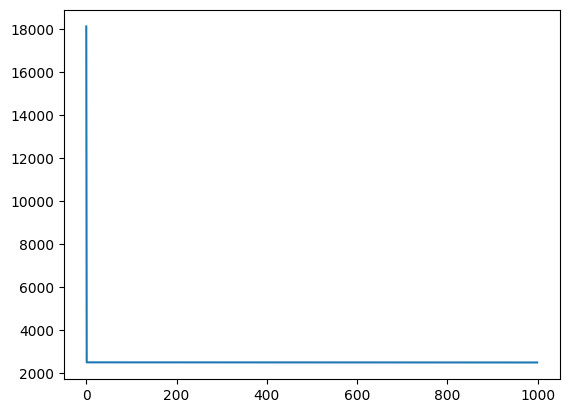

In [15]:
import matplotlib.pyplot as plt

plt.plot(history)

In [16]:
print(forward1.state_dict())

OrderedDict({'betas': tensor([[-0.2035],
        [-0.9186],
        [-0.9945]]), 'sigma': tensor([0.1346])})


In [17]:
# test MSE?

S = 0

for xx, yy in test_loader:
    uhat = forward2(xx)
    sum_loss = torch.sum((yy-uhat)**2)
    S += sum_loss

print(S/len(test_loader.dataset))

tensor(174.4150, grad_fn=<DivBackward0>)


model1의 mse가 model2보다 더 작기 때문에 설명변수를 2개를 사용했을 때, 더 성능이 좋음을 알 수 있다.

## 4.2 HW problem
We consider the built-in dataset **`warpbreaks`**, which describes the effect of  
- wool **type** (`A` or `B`) and  
- **tension** (`low`, `medium`, or `high`)  

on the number of warp breaks per loom.  
The response variable is **`breaks`**, a count of the number of breaks.  
The predictor variables are **`type`** and **`tension`**.

Our goal is to compare the following three Poisson models (do not forget to have exponantial activation function):

- **Model 1:**  
  `breaks ~ type`

- **Model 2:**  
  `breaks ~ tension`

- **Model 3:**  
  `breaks ~ type + tension`

---

### Questions

1. **Estimate the parameters using the MLE** for each of the three models (use custom layer with both forward and loss functions in it).

2. **Compute train AIC** for each model based on your parameter estimates.  
   Which model is better in terms of AIC?

### Hint 1:

1. You want use the below code to extract the data.
2. Make dataset and dataloader first.
3. Since the predictors are categorical, I have converted them into dummy variables before feeding them into your model. See Hint 2 and 3 to see how this dummy variables work.

In [18]:
import csv
import torch

# -------------------------------------------------------
# 1. Load CSV manually
# -------------------------------------------------------
filename = "warpbreaks.csv"

rows = []
with open(filename, "r") as f:
    reader = csv.reader(f)
    header = next(reader)   # breaks, wool, tension
    for row in reader:
        rows.append(row)

print("Header:", header)
print("First 3 rows:", rows[:3])

# -------------------------------------------------------
# 2. Prepare lists for each variable
# -------------------------------------------------------
breaks_list = []
wool_list   = []
tension_list = []

for row in rows:
    b, w, t = row

    breaks_list.append(float(b))
    wool_list.append(w)
    tension_list.append(t)

# -------------------------------------------------------
# 3. Manual dummy encoding
# -------------------------------------------------------
tension_map = {
    "L": (0.0, 0.0),
    "M": (1.0, 0.0),
    "H": (0.0, 1.0)
}

wool_map = {
    "A": 0.0,
    "B": 1.0
}

# -------------------------------------------------------
# 4. Build full matrix: [breaks, intercept, X1, X2, X3]
#    where intercept = 1.0
# -------------------------------------------------------
data_matrix = []

for i in range(len(breaks_list)):
    t1, t2 = tension_map[tension_list[i]]
    x3 = wool_map[wool_list[i]]

    row = [
        breaks_list[i],  # y
        1.0,             # intercept
        t1,              # X1 = tension_M
        t2,              # X2 = tension_H
        x3               # X3 = wool_B
    ]
    data_matrix.append(row)

data = torch.tensor(data_matrix, dtype=torch.float32)

print("Full tensor shape:", data.shape)
print(data[:5])

# -------------------------------------------------------
# 5. Shuffle the entire tensor
# -------------------------------------------------------
n = data.shape[0]
perm = torch.randperm(n)
shuffled = data[perm]

# -------------------------------------------------------
# 6. 70% train / 30% test split
# -------------------------------------------------------
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# -------------------------------------------------------
# 7. Split into X and y
# -------------------------------------------------------
y_train = train[:, 0:1]      # breaks
X_train = train[:, 1:]       # intercept + X1 + X2 + X3

y_test = test[:, 0:1]
X_test = test[:, 1:]

print("Train X:", X_train.shape)  # should be (n_train, 4)
print("Train y:", y_train.shape)
print("Test X:",  X_test.shape)   # should be (n_test, 4)
print("Test y:",  y_test.shape)



Header: ['breaks', 'wool', 'tension']
First 3 rows: [['26', 'A', 'L'], ['30', 'A', 'L'], ['54', 'A', 'L']]
Full tensor shape: torch.Size([54, 5])
tensor([[26.,  1.,  0.,  0.,  0.],
        [30.,  1.,  0.,  0.,  0.],
        [54.,  1.,  0.,  0.,  0.],
        [25.,  1.,  0.,  0.,  0.],
        [70.,  1.,  0.,  0.,  0.]])
Train X: torch.Size([37, 4])
Train y: torch.Size([37, 1])
Test X: torch.Size([17, 4])
Test y: torch.Size([17, 1])


In [19]:
X_train[:10]

tensor([[1., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [1., 0., 0., 1.],
        [1., 1., 0., 1.],
        [1., 0., 0., 1.],
        [1., 1., 0., 0.],
        [1., 1., 0., 1.],
        [1., 0., 0., 0.],
        [1., 0., 1., 1.]])

In [20]:
X_train.shape, X_test.shape

(torch.Size([37, 4]), torch.Size([17, 4]))

In [21]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

train = TensorDataset(X_train, y_train)
train_loader = DataLoader(train, shuffle=True, batch_size=10)

test = TensorDataset(X_test, y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=10)

### Hint 2: Dummy Encoding

Categorical variables such as `"wool"` (A/B) or `"tension"` (L/M/H) cannot be used directly in most statistical or machine learning models. To include them as predictors, we must convert them into numerical form.

One commonly used approach is **dummy encoding**.  
In dummy encoding:

- A categorical variable with **K categories** is represented using **K−1 binary indicator variables**.
- One category is treated as the **baseline**, and the remaining categories are encoded with dummy variables that take the value 0 or 1.

This creates numerical predictor columns while avoiding the multicollinearity problem that occurs with full one-hot encoding.

For example, suppose we have a variable with three categories:

- Red  
- Green  
- Blue  

We can encode these using **two** dummy variables:

| Category | Encoded value (X1, X2) |
|----------|------------------------|
| Red      | (0, 0)                |
| Green    | (1, 0)                |
| Blue     | (0, 1)                |

Here:

- **Red** is the baseline category  
- **X1** represents Green  
- **X2** represents Blue  
- The intercept absorbs the baseline effect

---

```
### Toy Example in PyTorch

```python
import torch

# Suppose the categorical variable has 3 levels:
# 0 = Red, 1 = Green, 2 = Blue
cats = torch.tensor([2, 0, 1, 2], dtype=torch.long)

# We will create two dummy variables (X1, X2)
# Baseline category: Red → (0,0)
X = torch.zeros((len(cats), 2))

for i, c in enumerate(cats):
    if c == 1:          # Green
        X[i, 0] = 1
    elif c == 2:        # Blue
        X[i, 1] = 1
    # If c == 0 (Red), leave as (0,0)

print("Dummy-encoded matrix:")
print(X)
```

### Hint 3: Back to our problem




We have


| tension | dummy encoding (X1, X2) |
|---------|--------------------------|
| L       | (0, 0)                  |
| M       | (1, 0)                  |
| H       | (0, 1)                  |

| wool | dummy encoding (X3) |
|------|----------------------|
| A    | 0                    |
| B    | 1                    |


Now you have columns for `X1`, `X2`, and `X3` as well as intercept column. Hence your matrix `X` for the explanatory variable is a shape of `[n, 4]`.




In [22]:
class PoissonRegModel(torch.nn.Module):
    def __init__(self, p):
        super().__init__()
        # parameters
        self.betas = torch.nn.Parameter(torch.randn([p,1]),requires_grad=True)

    def forward(self, X):
        lam = torch.exp(X@self.betas)
        return lam

    def loss(self, lam, y):
        ll = -lam + y*torch.log(lam) - torch.lgamma(y+1)
        return -torch.sum(ll)

### **Model 1**

In [23]:
model2_1 = PoissonRegModel(2)
optimizer2_1 = torch.optim.SGD(model2_1.parameters(), lr=0.001)

history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        xx = xx[:,[0,3]]
        lam = model2_1.forward(xx)
        loss = model2_1.loss(lam,yy)
        loss.backward()
        optimizer2_1.step()
        optimizer2_1.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

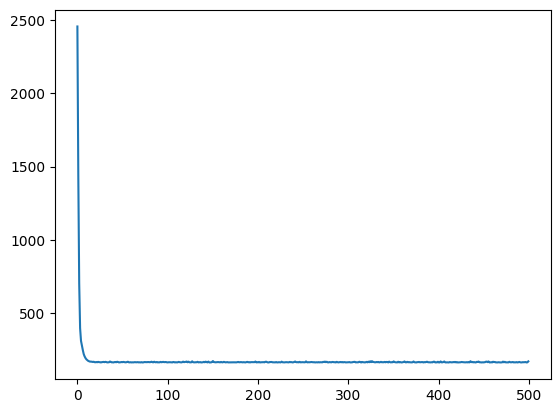

In [24]:
import matplotlib.pyplot as plt

plt.plot(history)

In [25]:
model2_1.betas

Parameter containing:
tensor([[3.2455],
        [0.0213]], requires_grad=True)

In [26]:
# AIC 구하기
def logl_pois(y_hat, y):
    ll = -y_hat + y*torch.log(y_hat) - torch.lgamma(y+1)
    return torch.sum(ll)

In [27]:
log_lik_1 = 0
for xx, yy in train_loader:
    xx =xx[:,[0,3]]
    y_hat = torch.exp(xx@model2_1.betas)
    log_lik_1 = log_lik_1 + logl_pois(y_hat, yy).item()

AIC_model1 = 2*2 - 2*log_lik_1
print(AIC_model1)

335.5485305786133


### **Model 2**

In [28]:
model2_2 = PoissonRegModel(3)
optimizer2_2 = torch.optim.SGD(model2_2.parameters(), lr=0.001)

history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        xx = xx[:,[0,1,2]]
        lam = model2_2.forward(xx)
        loss = model2_2.loss(lam,yy)
        loss.backward()
        optimizer2_2.step()
        optimizer2_2.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

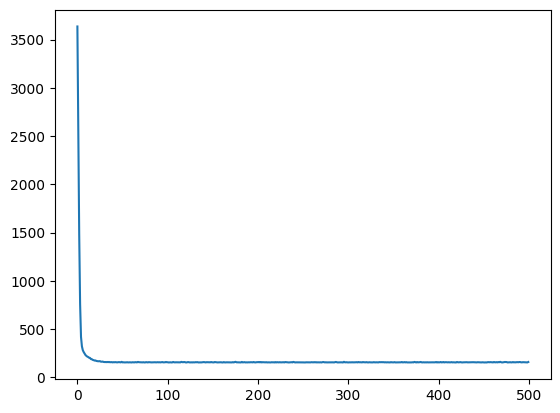

In [29]:
import matplotlib.pyplot as plt

plt.plot(history)

In [30]:
model2_2.betas

Parameter containing:
tensor([[ 3.5073],
        [-0.1505],
        [-0.3620]], requires_grad=True)

In [31]:
# AIC 구하기
def logl_pois(y_hat, y):
    ll = -y_hat + y*torch.log(y_hat) - torch.lgamma(y+1)
    return torch.sum(ll)

In [32]:
log_lik_2 = 0
for xx, yy in train_loader:
    xx =xx[:,[0,1,2]]
    y_hat = torch.exp(xx@model2_2.betas)
    log_lik_2 = log_lik_2 + logl_pois(y_hat, yy).item()

AIC_model2 = 2*3 - 2*log_lik_2
print(AIC_model2)

316.4124450683594


### **Model 3**

In [33]:
model2_3 = PoissonRegModel(4)
optimizer2_3 = torch.optim.SGD(model2_3.parameters(), lr=0.001)

history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        lam = model2_3.forward(xx)
        loss = model2_3.loss(lam,yy)
        loss.backward()
        optimizer2_3.step()
        optimizer2_3.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

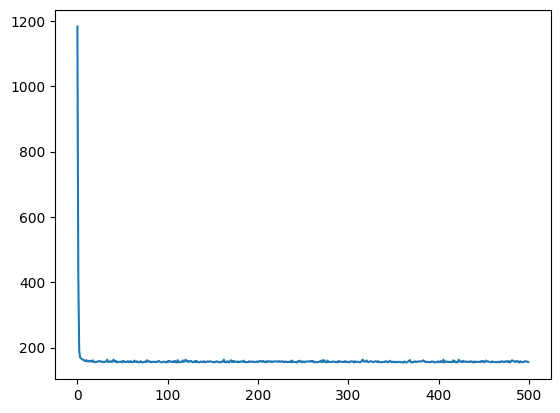

In [34]:
import matplotlib.pyplot as plt

plt.plot(history)

In [35]:
model2_3.betas

Parameter containing:
tensor([[ 3.4673],
        [-0.1629],
        [-0.3823],
        [ 0.0183]], requires_grad=True)

In [36]:
log_lik_3 = 0
for xx, yy in train_loader:
    y_hat = torch.exp(xx@model2_3.betas)
    log_lik_3 = log_lik_3 + logl_pois(y_hat, yy).item()

AIC_model3 = 2*4 - 2*log_lik_3
print(AIC_model3)

316.2663345336914


AIC는 모델의 복잡도와 모델의 데이터 설명도를 모두 반영하여 값이 낮을수록 더 좋은 모델이다. 즉, **Model 3이 가장 좋은 모델**이라고 할 수 있다.

## 4.3 HW problem

You are given the Default data, and want to predict one will default(`y=1`) or not(`y=0`). You have explanatory variable `student`, `balance`, and `income`. You will make two models:

1. Model 1: Use `student` and `income` to predict the `default`.
2. Model 2: Use `student`, `income` and `balance` to predict the `default`.

In terms of test accuracy, which is better? (use custom layer with `forward` method and `loss` method in it.)

In [37]:
import csv
import torch

# -------------------------------------------------------
# 1. Load CSV file manually (no pandas)
# -------------------------------------------------------
filename = "Default_data.csv"

rows = []
with open(filename, "r") as f:
    reader = csv.reader(f)
    header = next(reader)   # skip header
    for row in reader:
        rows.append(row)

print("Header:", header)
print("First 3 rows:", rows[:3])

# -------------------------------------------------------
# 2. Convert categorical + numeric values
# -------------------------------------------------------
default_list = []
student_list = []
balance_list = []
income_list = []

for row in rows:
    default_str, student_str, balance_str, income_str = row

    # Yes/No → 1/0
    default = 1.0 if default_str.lower() == "yes" else 0.0
    student = 1.0 if student_str.lower() == "yes" else 0.0

    default_list.append(default)
    student_list.append(student)
    balance_list.append(float(balance_str))
    income_list.append(float(income_str))

# -------------------------------------------------------
# 3. Make a SINGLE tensor (X + y together)
#    Column order: balance, income, student, default
# -------------------------------------------------------
data_matrix = []
for i in range(len(default_list)):
    row = [
        balance_list[i],
        income_list[i],
        student_list[i],
        default_list[i]   # last column is y
    ]
    data_matrix.append(row)

data = torch.tensor(data_matrix, dtype=torch.float32)

print("Full tensor shape:", data.shape)
print(data[:3])

# -------------------------------------------------------
# 4. Shuffle entire dataset
# -------------------------------------------------------
n = data.shape[0]
perm = torch.randperm(n)
shuffled = data[perm]

# -------------------------------------------------------
# 5. Train/Test split (70/30)
# -------------------------------------------------------
n_train = int(n * 0.7)

train = shuffled[:n_train]
test  = shuffled[n_train:]

# -------------------------------------------------------
# 6. Split into X and y
# -------------------------------------------------------
X_train = train[:, :-1]   # all columns except last
y_train = train[:, -1:]   # last column only

X_test = test[:, :-1]
y_test = test[:, -1:]

print("Train X:", X_train.shape)
print("Train y:", y_train.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Header: ['default', 'student', 'balance', 'income']
First 3 rows: [['No', 'No', '729.526495207286', '44361.6250742669'], ['No', 'Yes', '817.180406555498', '12106.1347003149'], ['No', 'No', '1073.54916401173', '31767.1389473999']]
Full tensor shape: torch.Size([10000, 4])
tensor([[7.2953e+02, 4.4362e+04, 0.0000e+00, 0.0000e+00],
        [8.1718e+02, 1.2106e+04, 1.0000e+00, 0.0000e+00],
        [1.0735e+03, 3.1767e+04, 0.0000e+00, 0.0000e+00]])
Train X: torch.Size([7000, 3])
Train y: torch.Size([7000, 1])
Test X: torch.Size([3000, 3])
Test y: torch.Size([3000, 1])


In [38]:
# 정규화
ones = torch.ones([X_train.shape[0],1])

X_train_mean = torch.mean(X_train[:,[0,1]], axis=0)
X_train_sd = torch.std(X_train[:,[0,1]], axis=0)
XX = (X_train[:,[0,1]] - X_train_mean)/X_train_sd
XXX_train = torch.concat([ones, XX, X_train[:,[2]]], axis=1)

ones = torch.ones([X_test.shape[0],1])
XX = (X_test[:,[0,1]] - X_train_mean)/X_train_sd
XXX_test = torch.concat([ones, XX, X_test[:,[2]]], axis=1)

In [39]:
XXX_train[:10,:]

tensor([[ 1.0000, -0.1403, -0.4539,  1.0000],
        [ 1.0000,  0.5135, -0.0712,  0.0000],
        [ 1.0000,  0.1553,  1.0009,  0.0000],
        [ 1.0000, -1.6812, -0.2413,  0.0000],
        [ 1.0000,  0.7745, -0.9835,  1.0000],
        [ 1.0000, -1.5329,  1.3034,  0.0000],
        [ 1.0000, -1.0458, -1.0503,  1.0000],
        [ 1.0000,  1.1310,  0.3606,  0.0000],
        [ 1.0000, -0.0461, -1.6125,  1.0000],
        [ 1.0000,  1.6528,  0.0311,  0.0000]])

In [40]:
train = TensorDataset(XXX_train, y_train)
train_loader = DataLoader(train, shuffle=True, batch_size=100)

test = TensorDataset(XXX_test, y_test)
test_loader = DataLoader(test, shuffle=False, batch_size=100)

In [41]:
class LogisticRegModel(torch.nn.Module):
    def __init__(self,p):
        super().__init__()
        self.betas = torch.nn.Parameter(torch.randn([p,1]), requires_grad=True)

    def forward(self, X):
        pp = torch.sigmoid(X@self.betas)
        return pp

    def loss(self, pp, y):
        ll = y*torch.log(pp)+(1-y)*torch.log(1-pp)
        return -torch.sum(ll)

### **Model 1**

In [42]:
model3_1 = LogisticRegModel(3)
optimizer3_1 = torch.optim.SGD(model3_1.parameters(), lr=0.001)

history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        xx = xx[:,[0,3,2]]
        pp = model3_1.forward(xx)
        loss = model3_1.loss(pp,yy)
        loss.backward()
        optimizer3_1.step()
        optimizer3_1.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

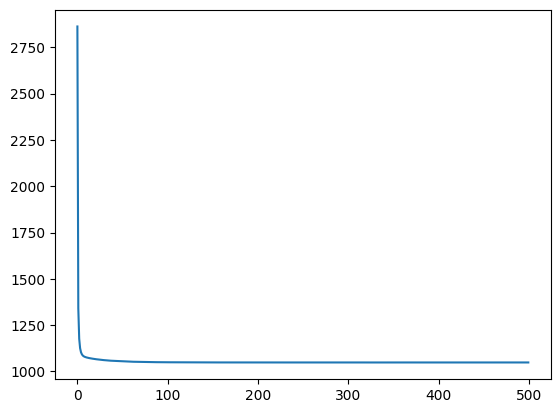

In [43]:
plt.plot(history)

In [44]:
model3_1.betas

Parameter containing:
tensor([[-3.4879],
        [ 0.5005],
        [ 0.0872]], requires_grad=True)

In [45]:
# test mse
sum_square = 0
for xx, yy in test_loader:
    xx = xx[:,[0,3,2]]
    yy_hat = torch.sigmoid(xx@model3_1.betas)
    sum_square = sum_square + torch.sum((yy - yy_hat)**2)

test_mse = sum_square/len(test_loader.dataset)
test_mse

tensor(0.0294, grad_fn=<DivBackward0>)

In [46]:
# test_accuracy
sum_correct = 0
all_preds = []
all_labels = []

for xx, yy in test_loader:
    xx = xx[:,[0,3,2]]
    pp_hat = torch.sigmoid(xx@model3_1.betas)

    yy_hat = (pp_hat >= 0.5).float()

    sum_correct += (yy_hat==yy).sum().item()

    all_preds.extend(yy_hat.numpy())
    all_labels.extend(yy.numpy())

test_accuracy = sum_correct / len(test_loader.dataset)
test_accuracy

0.9696666666666667

### **Model 2**

In [47]:
model3_2 = LogisticRegModel(4)
optimizer3_2 = torch.optim.SGD(model3_2.parameters(), lr=0.001)

history = []

for i in range(500):
    LOSS = 0
    for xx, yy in train_loader:
        xx = xx[:,[0,3,2,1]]
        pp = model3_2.forward(xx)
        loss = model3_2.loss(pp,yy)
        loss.backward()
        optimizer3_2.step()
        optimizer3_2.zero_grad()
        LOSS += loss.item()
    history.append(LOSS)

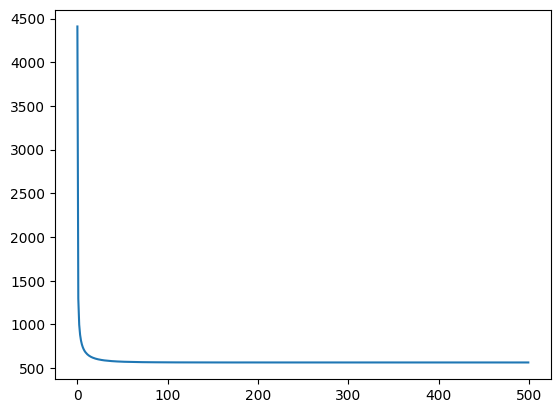

In [48]:
plt.plot(history)

In [49]:
model3_2.betas

Parameter containing:
tensor([[-5.9853],
        [-0.6212],
        [ 0.0760],
        [ 2.8159]], requires_grad=True)

In [50]:
# test mse
sum_square = 0
for xx, yy in test_loader:
    xx = xx[:,[0,3,2,1]]
    yy_hat = torch.sigmoid(xx@model3_2.betas)
    sum_square = sum_square + torch.sum((yy - yy_hat)**2)

test_mse = sum_square/len(test_loader.dataset)
test_mse

tensor(0.0193, grad_fn=<DivBackward0>)

In [51]:
# test_accuracy
sum_correct = 0
all_preds = []
all_labels = []

for xx, yy in test_loader:
    xx = xx[:,[0,3,2,1]]
    pp_hat = torch.sigmoid(xx@model3_2.betas)

    yy_hat = (pp_hat >= 0.5).float()

    sum_correct += (yy_hat==yy).sum().item()

    all_preds.extend(yy_hat.numpy())
    all_labels.extend(yy.numpy())

test_accuracy = sum_correct / len(test_loader.dataset)
test_accuracy

0.9763333333333334

model1과 비교했을 때, model2의 mse가 더 작고, accuracy가 더 높기 때문에 설명변수가 더 많은 model2가 더 좋은 모델이라고 볼 수 있다.